In [2]:
import numpy as np
import scipy 
import skbio
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

# Calculate beta diversity using species abundance


In [3]:
#load metaphlan2 species abundance

df_species=pd.read_csv('./data/metaphlan2_species_level_abundance_classified.csv',index_col=0)
df_species=df_species.fillna(value=0)

#load the species abundance profile with species name abundance replaced by taxonID
# This is to ensure the consistency between phylo tree and abundance profile
df_spe_taxID=pd.read_csv('./data/metaphlan2_species_abundance_taxonID.csv',index_col=0)
df_spe_taxID=df_spe_taxID.fillna(value=0)

In [4]:
##load metadata 
df_meta=pd.read_csv('./data/metadata_updated_filtered_201909.csv',index_col=0)
df_meta=df_meta.fillna(value=4)

#filter the metadata so it only contains the samples in the species abundance 
df_meta_301=df_meta.loc[df_species.columns]

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


## Calculate diversity with phylogenetic metric: unweighted_unifrac

In [5]:
from skbio import TreeNode
from io import StringIO

# load phylogenetic tree built in the preprocessing notebook
with open('./data/phylotree_sandborn.nw', 'r') as myfile:
    data=myfile.read()
tree=TreeNode.read(StringIO(data))

In [6]:
#preprocess data 
from skbio.diversity import beta_diversity

df=df_spe_taxID.transpose()
data_pre=100000*pd.DataFrame.as_matrix(df_spe_taxID.transpose())
data=data_pre.astype(int)
ids=df.index
otuid=[str(i) for i in df.columns]
bc_dm = beta_diversity("unweighted_unifrac",data,ids,otu_ids=otuid, tree=tree)

#np.savetxt('./data/unifrac_pairwise_distance_species.txt', bc_dm.data)

In [7]:
#plot PcoA plot
from skbio.stats.ordination import pcoa
bc_pc = pcoa(bc_dm)

#check the variance explained by each PC 
bc_pc.proportion_explained

/usr/local/lib/python3.4/dist-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.07173470940430338 and the largest is 11.041460239057782.
  RuntimeWarning


PC1      0.167363
PC2      0.062520
PC3      0.053800
PC4      0.030213
PC5      0.026548
PC6      0.025488
PC7      0.024626
PC8      0.021625
PC9      0.019365
PC10     0.019066
PC11     0.017968
PC12     0.016442
PC13     0.015843
PC14     0.014772
PC15     0.014524
PC16     0.013804
PC17     0.013352
PC18     0.012871
PC19     0.012665
PC20     0.012112
PC21     0.011396
PC22     0.010952
PC23     0.010605
PC24     0.010516
PC25     0.009651
PC26     0.009458
PC27     0.009260
PC28     0.008931
PC29     0.008862
PC30     0.008486
           ...   
PC272    0.000000
PC273    0.000000
PC274    0.000000
PC275    0.000000
PC276    0.000000
PC277    0.000000
PC278    0.000000
PC279    0.000000
PC280    0.000000
PC281    0.000000
PC282    0.000000
PC283    0.000000
PC284    0.000000
PC285    0.000000
PC286    0.000000
PC287    0.000000
PC288    0.000000
PC289    0.000000
PC290    0.000000
PC291    0.000000
PC292    0.000000
PC293    0.000000
PC294    0.000000
PC295    0.000000
PC296    0

### PCoA labeled by collection time to check batch effect

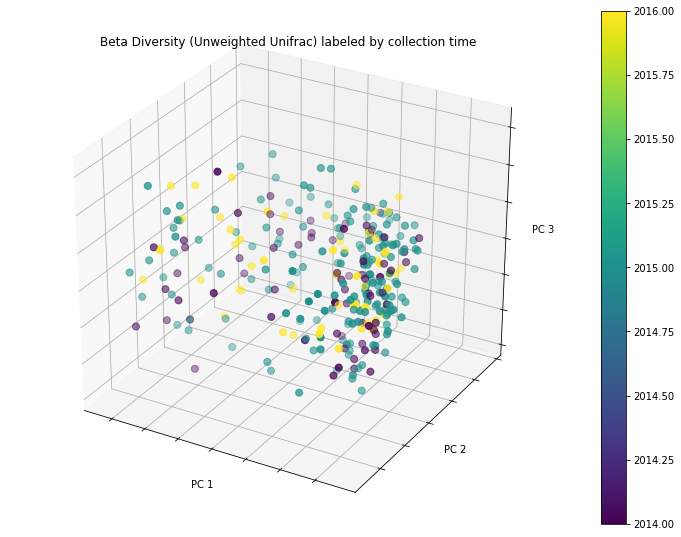

In [7]:
fig=bc_pc.plot(df_meta,'collection_timestamp',
                axis_labels=('PC 1', 'PC 2', 'PC 3'),cmap='viridis',
                  s=50,title='Beta Diversity (Unweighted Unifrac) labeled by collection time')
fig.set_size_inches(12, 8)

#fig.savefig('./data/PcoA_collectiontime.svg')


### PCoA labeled by surgery subtype

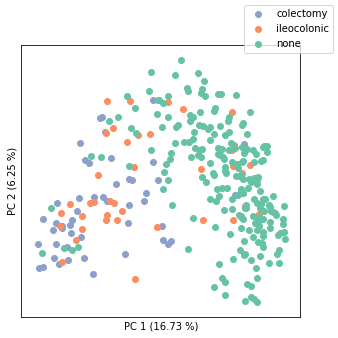

In [8]:
# plot the first two components only

df_meta['PC 1 (16.73 %)'] = bc_pc.samples['PC1']
df_meta['PC 2 (6.25 %)'] = bc_pc.samples['PC2']

colors = {
    'ileocolonic': '#fc8d62',
    'colectomy': '#8da0cb',
    'none': '#66c2a5',
    'n': '#66c2a5',
    'y': '#e78ac3'
}

fig, ax = plt.subplots()
fig.set_size_inches(5,5)
for cat, _data in df_meta.groupby('surgery_type2'):
    ax.scatter(x='PC 1 (16.73 %)', y='PC 2 (6.25 %)', data=_data, c=colors[cat], label=cat)
    ax.set_xlabel('PC 1 (16.73 %)')
    ax.set_ylabel('PC 2 (6.25 %)')

plt.xticks([],[])
plt.yticks([],[])
fig.legend()
#fig.savefig('../data/Sandborn_data/figures/PCoA_surgery_status.svg')
#fig.savefig('../data/Sandborn_data/figures/PCoA_surgery_status.pdf')

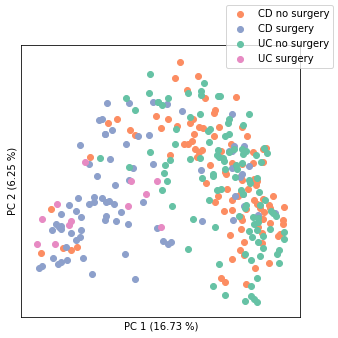

In [10]:
#PCoA labeled stratified surgery and disease subtypes
label1=[]

for i in df_meta.index: 
    row=df_meta.loc[i]
    if row.disease=='cd': 
        if row.surgery_type2=='none': 
            label1.append('CD no surgery')
        else: 
            label1.append('CD surgery')
    else: 
        if row.surgery_type2=='none': 
            label1.append('UC no surgery')
        else: 
            label1.append('UC surgery')      
df_meta['label1']=label1

# plot the first two components only

df_meta['PC 1 (16.73 %)'] = bc_pc.samples['PC1']
df_meta['PC 2 (6.25 %)'] = bc_pc.samples['PC2']

colors2 = {
    'CD no surgery': '#fc8d62',
    'CD surgery': '#8da0cb',
    'UC no surgery': '#66c2a5',
    'UC surgery': '#e78ac3',
    'y': '#'
}

fig, ax = plt.subplots()
fig.set_size_inches(5,5)
for cat, _data in df_meta.groupby('label1'):
    ax.scatter(x='PC 1 (16.73 %)', y='PC 2 (6.25 %)', data=_data, c=colors2[cat], label=cat)
    ax.set_xlabel('PC 1 (16.73 %)')
    ax.set_ylabel('PC 2 (6.25 %)')

plt.xticks([],[])
plt.yticks([],[])
fig.legend()
fig.savefig('../../../data/Sandborn_data/figures/figureS2A.svg')


### PCoA labeled by E.coli Abundance

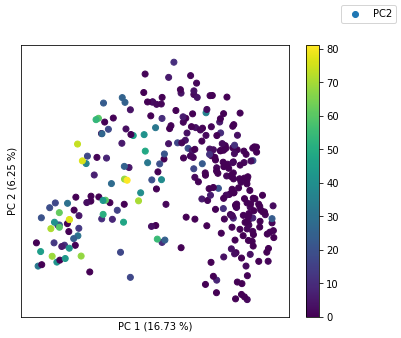

In [11]:
# plot the first two components only

fig, ax = plt.subplots()
fig.set_size_inches(6,5)
plot=ax.scatter(x= bc_pc.samples['PC1'] , y= bc_pc.samples['PC2'], data=_data, c=df_spe_taxID.T[1005520],cmap='viridis')
ax.set_xlabel('PC 1 (16.73 %)')
ax.set_ylabel('PC 2 (6.25 %)')
plt.xticks([],[])
plt.yticks([],[])
fig.colorbar(plot)
fig.legend()
#fig.savefig('../data/Sandborn_data/figures/PCoA_ecoli.svg')
#fig.savefig('../data/Sandborn_data/figures/PCoA_ecoli.pdf')

# Calculate beta diversity using pathway abundance

In [12]:
#load metaphlan2 species abundance

df_pathway=pd.read_csv('./data/Filtered_normalized_cpm_pathways_new_unstratified.csv',index_col=0)
df_pathway=df_pathway.fillna(value=0)

In [13]:
#preprocess data 
from skbio.diversity import beta_diversity

df=df_pathway.transpose()
data_pre=100000*pd.DataFrame.as_matrix(df_pathway.transpose())
data=data_pre.astype(int)
ids=df.index
otuid=[str(i) for i in df.columns]
bc_dm = beta_diversity("braycurtis",data,ids)

In [14]:
#plot PcoA plot
from skbio.stats.ordination import pcoa
bc_pc = pcoa(bc_dm)
bc_pc.proportion_explained

/usr/local/lib/python3.4/dist-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.09705409425153998 and the largest is 7.699865152131392.
  RuntimeWarning


PC1      0.389931
PC2      0.107738
PC3      0.066410
PC4      0.049979
PC5      0.045982
PC6      0.029084
PC7      0.025878
PC8      0.021967
PC9      0.014485
PC10     0.013637
PC11     0.012611
PC12     0.011651
PC13     0.011135
PC14     0.008851
PC15     0.008627
PC16     0.008186
PC17     0.008091
PC18     0.007488
PC19     0.006979
PC20     0.006287
PC21     0.005674
PC22     0.005233
PC23     0.005073
PC24     0.004949
PC25     0.004324
PC26     0.004194
PC27     0.003989
PC28     0.003799
PC29     0.003719
PC30     0.003591
           ...   
PC271    0.000000
PC272    0.000000
PC273    0.000000
PC274    0.000000
PC275    0.000000
PC276    0.000000
PC277    0.000000
PC278    0.000000
PC279    0.000000
PC280    0.000000
PC281    0.000000
PC282    0.000000
PC283    0.000000
PC284    0.000000
PC285    0.000000
PC286    0.000000
PC287    0.000000
PC288    0.000000
PC289    0.000000
PC290    0.000000
PC291    0.000000
PC292    0.000000
PC293    0.000000
PC294    0.000000
PC295    0

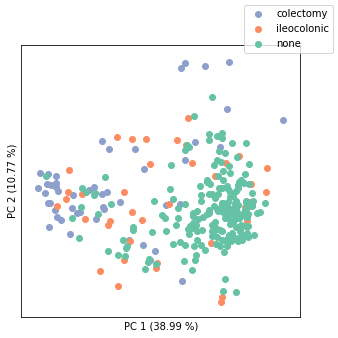

In [15]:
import matplotlib.pyplot as plt
df_meta['PC 1 (38.99 %)'] = bc_pc.samples['PC1']
df_meta['PC 2 (10.77 %)'] = bc_pc.samples['PC2']

fig, ax = plt.subplots()
fig.set_size_inches(5,5)
for cat, _data in df_meta.groupby('surgery_type2'):
    ax.scatter(x='PC 1 (38.99 %)', y='PC 2 (10.77 %)', data=_data, c=colors[cat], label=cat)
    ax.set_xlabel('PC 1 (38.99 %)')
    ax.set_ylabel('PC 2 (10.77 %)')

plt.xticks([],[])
plt.yticks([],[])
fig.legend()


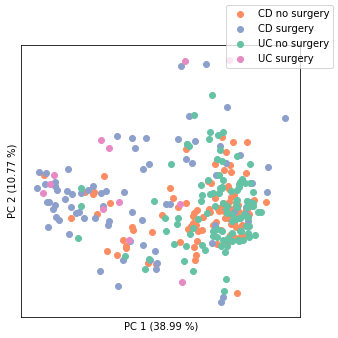

In [16]:
# plot the first two components only

df_meta['PC 1 (38.99 %)'] = bc_pc.samples['PC1']
df_meta['PC 2 (10.77 %)'] = bc_pc.samples['PC2']

colors2 = {
    'CD no surgery': '#fc8d62',
    'CD surgery': '#8da0cb',
    'UC no surgery': '#66c2a5',
    'UC surgery': '#e78ac3',
    'y': '#'
}

fig, ax = plt.subplots()
fig.set_size_inches(5,5)
for cat, _data in df_meta.groupby('label1'):
    ax.scatter(x='PC 1 (38.99 %)', y='PC 2 (10.77 %)', data=_data, c=colors2[cat], label=cat)
    ax.set_xlabel('PC 1 (38.99 %)')
    ax.set_ylabel('PC 2 (10.77 %)')

plt.xticks([],[])
plt.yticks([],[])
fig.legend()
fig.savefig('../../../data/Sandborn_data/figures/figureS2B.svg')
